In [76]:
import pandas as pd
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns
import os

from glob import glob
from collections import Counter
from pathlib import Path

import utils.merge_tools as M

pd.set_option('future.no_silent_downcasting', True)

In [2]:
data_dir = '../data/processed/grouped/new_aggs/'
base_file = '../data/raw/csv_files/train/train_base.csv'

## Load Data

Function heavily weights random sampling towards minority class.

In [16]:
n_ids = 150000

df = M.merge_n_case_ids(
    n_ids=n_ids,
    data_dir=data_dir,
    path_to_base=base_file,
    use_0=True,
    as_pandas=False,
    random_state=28
)
case_ids_list = list(df['case_id'])

df_rest = M.merge_n_case_ids(
    n_ids=n_ids,
    data_dir=data_dir,
    path_to_base=base_file,
    use_0=False,
    as_pandas=False,
    case_id_list=case_ids_list,
    random_state=28
)

In [36]:
# Merge personal and non-personal
df_full = df.join(df_rest, on=['case_id', 'date_decision', 'WEEK_NUM'], how='left')

# Separate 'date_decision'
df_dd = M.separate_dates(df_full, ['date_decision'])
df_full = pl.concat([df_full, df_dd], how='horizontal')
df_full = df.drop(['date_decision', 'case_id', 'MONTH', 'WEEK_NUM'])

## Data Cleaning

In [38]:
Counter(df_full.dtypes)

Counter({Float64: 743,
         Int8: 493,
         Int32: 66,
         UInt32: 40,
         Boolean: 14,
         Int64: 1})

In [39]:
# Create is_null columns
df_is_null = M.create_is_null_cols(df_full)

In [65]:
# Create pandas DataFrame
df_new = df_is_null.to_pandas()

# Drop empty columns
df_new = df_new.dropna(how='all', axis=1)

# Create total nulls column
nulls_col = pd.Series(df_new.isnull().sum(axis=1), name='total_nulls')
df_new = pd.concat([df_new, nulls_col], axis=1)

In [66]:
# Get object columns and cast as bool
obj_cols = df_new.select_dtypes('object').columns
for col in obj_cols:
    df_new[col] = df_new[col].fillna(False).astype(bool)

In [68]:
# Remove columns with more than 95% missing values
missing_threshold = 0.95
df_filtered = df_new[df_new.columns[df_new.isnull().mean() < missing_threshold]]

In [70]:
df_new.shape, df_filtered.shape

((150000, 2549), (150000, 2218))

## EDA

There appears to be multiple clusters of `case_id`s in the dataset.  We will further investigate at the depth 1 and 2 level.

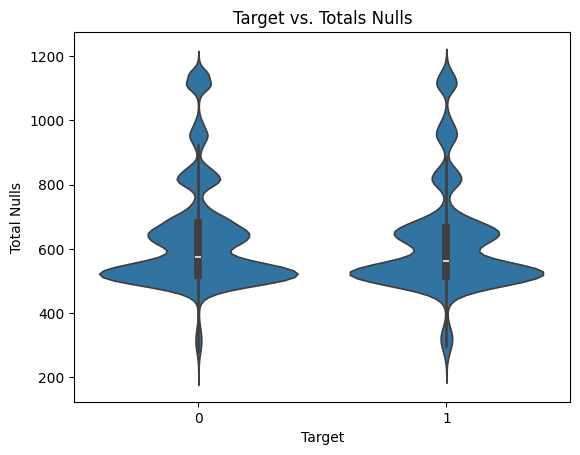

In [72]:
sns.violinplot(data=df_filtered, x='target', y='total_nulls')

plt.title('Target vs. Totals Nulls')
plt.ylabel('Total Nulls')
plt.xlabel('Target')

plt.show()

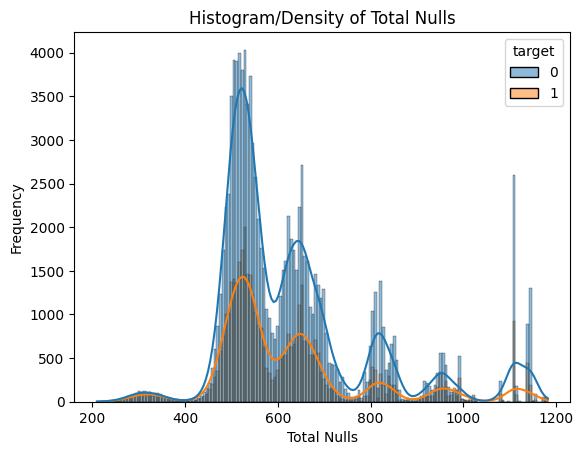

In [74]:
sns.histplot(data=df_filtered, x='total_nulls', hue='target', kde=True)

plt.xlabel('Total Nulls')
plt.ylabel('Frequency')
plt.title('Histogram/Density of Total Nulls')

plt.show()